In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=0e6709714a380dec3946910d5bf2e361359ed01b94d37f3220b206127f32ebea
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
#Imports
import pandas as pd
import numpy as np
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')


# Data Acquisition

In [ ]:
## Download the data
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Cast the symbols and take the unique ones
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

symbols_list = sp500['Symbol'].unique().tolist()

# Stablish dates range 8 years before end_date
end_date = '2023-09-27'
start_date= pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end= end_date)

df.head()


[*********************100%%**********************]  503 of 503 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['VLTO', 'SOLV', 'GEV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price       Adj Close                                                   \
Ticker              A        AAL       AAPL       ABBV ABNB        ABT   
Date                                                                     
2015-09-29  31.483549  37.361622  24.651136  36.334904  NaN  33.478710   
2015-09-30  32.034100  37.027866  24.931416  37.449932  NaN  34.088951   
2015-10-01  31.483549  37.380695  24.768671  37.945503  NaN  34.546627   
2015-10-02  32.351372  36.837151  24.949495  38.420425  NaN  35.072124   
2015-10-05  32.976547  38.324741  25.039909  39.012352  NaN  35.080585   

Price                                                   ...  Volume           \
Ticker           ACGL        ACN       ADBE        ADI  ...     WTW       WY   
Date                                                    ...                    
2015-09-29  24.416668  83.468369  79.830002  45.338951  ...  345752  3053000   
2015-09-30  24.490000  84.902695  82.220001  47.318596  ...  649262  2837500   
2015-10-01  24.463333  85.058235  83.750000  46.085514  ...  527632  3270800   
2015-10-02  24.780001  85.879082  83.989998  46.714642  ...  367458  2846400   
2015-10-05  24.993334  87.805954  85.839996  48.174225  ...  179275  3286600   

Price                                                                       \
Ticker          WYNN      XEL       XOM      XYL      YUM      ZBH    ZBRA   
Date                                                                         
2015-09-29   6223400  3361700  13754400  1344100  6018857  2358906  895000   
2015-09-30   4265300  2722000  18176500  1708500  7378142  2012723  618800   
2015-10-01   4745600  2875200  14397800  1498600  4426718  1604019  464900   
2015-10-02  15153700  3299500  18811300  1451100  7719772  1353626  341500   
2015-10-05  12699700  5369400  18486700  2376800  5737736  1352081  460600   

Price                
Ticker          ZTS  
Date                 
2015-09-29  7328400  
2015-09-30  4954100  
2015-10-01  4131800  
2015-10-02  4036800  
2015-10-05  5467700  

[5 rows x 3018 columns]

In [ ]:
df= df.stack()
df.columns = df.columns.str.lower()
df.head()

Price              adj close      close       high        low       open  \
Date       Ticker                                                          
2015-09-29 A       31.483549  33.740002  34.060001  33.240002  33.360001   
           AAL     37.361622  39.180000  39.770000  38.790001  39.049999   
           AAPL    24.651136  27.264999  28.377501  26.965000  28.207500   
           ABBV    36.334904  52.790001  54.189999  51.880001  53.099998   
           ABT     33.478710  39.500000  40.150002  39.029999  39.259998   

Price                   volume  
Date       Ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0

# Features an technical indicators

In [ ]:
# Garman-Klaus Volatility
df['garman-klass vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# RSI
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x,length=20))

# Bolinger Bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x),length=20).iloc[:,2])

# ATR

## Create a function to apply to each column as 3 inpùt columns are needed
def compute_atr(stock_data):
  atr = pandas_ta.atr(high=stock_data['high'],
                      low=stock_data['low'],
                      close=stock_data['close'],
                      length=14)
  # Normalize the data and return
  return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1,group_keys=False).apply(compute_atr) ## aplly the funcion with group_key to false to avoid duplicating the columns

# MACD
def compute_macd(close):
  macd= pandas_ta.macd(close=close,length=20).iloc[:,0]
  return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1,group_keys= False)['close'].apply(compute_macd)

#Dollar Volume
df['dollar_volume'] = df['adj close']*df['volume']/1e6

df.head()

Price              adj close      close       high        low       open  \
Date       Ticker                                                          
2015-09-29 A       31.483549  33.740002  34.060001  33.240002  33.360001   
           AAL     37.361622  39.180000  39.770000  38.790001  39.049999   
           AAPL    24.651136  27.264999  28.377501  26.965000  28.207500   
           ABBV    36.334904  52.790001  54.189999  51.880001  53.099998   
           ABT     33.478710  39.500000  40.150002  39.029999  39.259998   

Price                   volume  garman-klass vol  rsi  bb_low  bb_mid  \
Date       Ticker                                                       
2015-09-29 A         2252400.0         -0.000998  NaN     NaN     NaN   
           AAL       7478800.0         -0.000443  NaN     NaN     NaN   
           AAPL    293461600.0         -0.005712  NaN     NaN     NaN   
           ABBV     12842800.0         -0.054655  NaN     NaN     NaN   
           ABT      12287500.0         -0.009402  NaN     NaN     NaN   

Price              bb_high  atr  macd  dollar_volume  
Date       Ticker                                     
2015-09-29 A           NaN  NaN   NaN      70.913546  
           AAL         NaN  NaN   NaN     279.420098  
           AAPL        NaN  NaN   NaN    7234.161929  
           ABBV        NaN  NaN   NaN     466.641901  
           ABT         NaN  NaN   NaN     411.369651

# Aggregate to monthly level and fiter 150 most liquid stocks

In [ ]:
## Discard columns that are not metrics
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume','volume','open',
                                                           'high','low','close']]
# Take only the last value monthly of the metrics
monthly_metrics = df.unstack()[last_cols].resample('M').last().stack()

# Take the mean of the monthly dollar volume
mean_DV= df.unstack()['dollar_volume'].resample('M').mean().stack().to_frame('dollar_volume')

# Merge the dataframes

data = pd.concat([monthly_metrics,mean_DV],axis=1).dropna()
data.head()

adj close       atr   bb_high    bb_low    bb_mid  \
Date       Ticker                                                      
2015-11-30 A       39.023190 -1.033887  3.690888  3.545992  3.618440   
           AAL     39.429939  0.190822  3.827636  3.672028  3.749832   
           AAPL    26.854143 -0.967900  3.368302  3.281679  3.324990   
           ABBV    40.393536 -0.526809  3.823191  3.726695  3.774943   
           ABT     38.293556 -1.064842  3.699763  3.656055  3.677909   

                   garman-klass vol      macd        rsi  dollar_volume  
Date       Ticker                                                        
2015-11-30 A              -0.001992  0.612207  73.421505     135.992825  
           AAL            -0.000966 -0.448808  40.718975     287.915799  
           AAPL           -0.003307 -0.136303  55.537357    4023.983942  
           ABBV           -0.059549  0.269759  49.376886     337.563936  
           ABT            -0.011216  0.401647  56.962467     211.659055

In [ ]:
 # Calculate 5-year rolling average of dolar volume

# Calculate the rolling mean for 5-year
data['dollar_volume_5y'] = (data.loc[:,'dollar_volume'].unstack('Ticker').rolling(5*12,min_periods=12).mean().stack())

# Create a rank based on the dollar_volume
data['dollar_vol_rank'] = data.groupby(level=0)['dollar_volume_5y'].rank(ascending=False)

# Filter the top 150 .drop(['dollar_vol_rank','dollar_volume'],axis=1)


data = data[data['dollar_vol_rank'] < 150].drop(['dollar_vol_rank','dollar_volume','dollar_volume_5y'],axis=1)
data


adj close       atr   bb_high    bb_low    bb_mid  \
Date       Ticker                                                       
2016-10-31 AAL      39.134327  0.402199  3.706314  3.604673  3.655493   
           AAPL     26.212473 -1.038688  3.351997  3.294237  3.323117   
           ABBV     40.245113 -0.893132  3.861774  3.753446  3.807610   
           ABT      34.293457 -1.035224  3.655580  3.554632  3.605106   
           ACN     103.569618 -0.996806  4.660617  4.637342  4.648980   
...                       ...       ...       ...       ...       ...   
2023-09-30 VRTX    351.690002  0.029799  5.879295  5.838959  5.859127   
           VZ       31.258694 -1.078816  3.532000  3.467585  3.499792   
           WFC      39.781090 -0.558742  3.777782  3.697054  3.737418   
           WMT      53.597534 -0.196381  4.019915  3.984976  4.002446   
           XOM     113.372101  0.601335  4.767283  4.687091  4.727187   

                   garman-klass vol      macd        rsi  
Date       Ticker                                         
2016-10-31 AAL            -0.000176  1.156204  62.203558  
           AAPL           -0.002468 -0.183090  49.891063  
           ABBV           -0.046691 -0.879249  27.477876  
           ABT            -0.007492 -0.718206  38.008844  
           ACN            -0.004643 -0.198823  53.823641  
...                             ...       ...        ...  
2023-09-30 VRTX            0.000037  0.027907  52.406728  
           VZ             -0.000940 -0.219289  42.222504  
           WFC            -0.000110 -0.236222  40.920299  
           WMT            -0.000041  0.375138  54.722482  
           XOM            -0.000065  1.226542  59.440190  

[12516 rows x 8 columns]

# Calculate Monthy return dor different time horizons

In [ ]:
def calculate_returns(df):
  ## Set outliers to 0.5%
  outlier_cutoff = 0.005
  # Stablish the interval of months
  lags = [1,2,3,6,9,12]

  for lag in lags:

    df[f'return_{lag}m'] = (df['adj close'].pct_change(lag)
                            .pipe(lambda x : x.clip(lower=x.quantile(outlier_cutoff),
                                                    upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
  return df

data = data.groupby(level=1,group_keys=False).apply(calculate_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
Date       Ticker                                                       
2017-10-31 AAL      45.534168  1.011062  3.994389  3.849110  3.921750   
           AAPL     39.713898 -0.906642  3.688475  3.594730  3.641603   
           ABBV     67.491150  0.375557  4.289423  4.196702  4.243063   
           ABT      48.493374 -1.040044  3.939707  3.892568  3.916137   
           ACN     129.399734 -0.986514  4.882034  4.802675  4.842354   
...                       ...       ...       ...       ...       ...   
2023-09-30 VRTX    351.690002  0.029799  5.879295  5.838959  5.859127   
           VZ       31.258694 -1.078816  3.532000  3.467585  3.499792   
           WFC      39.781090 -0.558742  3.777782  3.697054  3.737418   
           WMT      53.597534 -0.196381  4.019915  3.984976  4.002446   
           XOM     113.372101  0.601335  4.767283  4.687091  4.727187   

                   garman-klass vol      macd        rsi  return_1m  \
Date       Ticker                                                     
2017-10-31 AAL            -0.000363 -0.015211  41.051782  -0.014108   
           AAPL           -0.001055 -0.020998  69.196819   0.096808   
           ABBV           -0.034008  0.558036  55.247866   0.022728   
           ABT            -0.005190  0.276618  53.844881   0.021276   
           ACN            -0.003925  0.306920  69.365305   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 VRTX            0.000037  0.027907  52.406728   0.009617   
           VZ             -0.000940 -0.219289  42.222504  -0.056889   
           WFC            -0.000110 -0.236222  40.920299  -0.015500   
           WMT            -0.000041  0.375138  54.722482  -0.000677   
           XOM            -0.000065  1.226542  59.440190   0.046947   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
Date       Ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 VRTX    -0.000923  -0.000208   0.018495   0.022140    0.016337  
           VZ      -0.016122  -0.033458  -0.021495  -0.014100   -0.006158  
           WFC     -0.057917  -0.013554   0.016712   0.000703    0.003255  
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  

[10346 rows x 14 columns]

# Download Fama-French Factors and Calculate Rolling Factor Betas

In [ ]:
factor_data=web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF',axis=1)
# Change the index to timepstamp
factor_data.index=factor_data.index.to_timestamp()
# Resample to monthly
factor_data=factor_data.resample('M').last().div(100)
#factor_data.index.name='date'

# Join both df

factor_data=factor_data.join(data['return_1m']).sort_index()
factor_data.xs('AAPL',level=1).head()


,Mkt-RF,SMB,HML,RMW,CMA,return_1m
Date,,,,,,
2017-10-31,0.0225,-0.0194,0.0020,0.0093,-0.0325,0.096808
2017-11-30,0.0312,-0.0033,-0.0003,0.0316,-0.0005,0.020278
2017-12-31,0.0106,-0.0107,0.0006,0.0074,0.0169,-0.015246
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,-0.010637
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,0.068185


In [ ]:
# Filter out stocks with less than 10 months of data
observation=factor_data.groupby(level=1).size()

valid_stocks=observation[observation >=10]
factor_data = factor_data[factor_data.index.get_level_values(level=1).isin(valid_stocks.index)]
factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056889
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000677
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10317 rows x 6 columns]

In [ ]:
# Calculate factor rolling betas

betas=(factor_data.groupby(level=1,group_keys=False)
  .apply(lambda x:RollingOLS(endog=x['return_1m'],
                             exog=sm.add_constant(x.drop('return_1m',axis=1)),
                             window=min(24,x.shape[0]),
                             min_nobs=len(x.columns)+1)
  .fit(params_only=True)
  .params
 .drop('const',axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
Date       Ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332655 -0.165644  0.267344  0.310366  0.106902
           WFC     1.121746  0.300521  2.061533 -0.439490 -1.517557
           WMT     0.700556 -0.315601 -0.413433 -0.142907  0.508471
           XOM     0.983511 -1.093761  1.756777 -0.640868 -0.368455

[10317 rows x 5 columns]

In [ ]:
factors= ['Mkt-RF',	'SMB'	,'HML'	,'RMW'	,'CMA']
## Join and shift
data = data.join(betas.groupby(level=1).shift())
## Fill NaN with the mean
data.loc[:,factors] = data.groupby(level=1,group_keys=False)[factors].apply(lambda x: x.fillna(x.mean())).dropna()
## Drop adj close columns and NaN if exixts
data=data.drop('adj close',axis=1).dropna()
data

atr   bb_high    bb_low    bb_mid  garman-klass vol  \
Date       Ticker                                                             
2017-10-31 AAL     1.011062  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.906642  3.688475  3.594730  3.641603         -0.001055   
           ABBV    0.375557  4.289423  4.196702  4.243063         -0.034008   
           ABT    -1.040044  3.939707  3.892568  3.916137         -0.005190   
           ACN    -0.986514  4.882034  4.802675  4.842354         -0.003925   
...                     ...       ...       ...       ...               ...   
2023-09-30 VRTX    0.029799  5.879295  5.838959  5.859127          0.000037   
           VZ     -1.078816  3.532000  3.467585  3.499792         -0.000940   
           WFC    -0.558742  3.777782  3.697054  3.737418         -0.000110   
           WMT    -0.196381  4.019915  3.984976  4.002446         -0.000041   
           XOM     0.601335  4.767283  4.687091  4.727187         -0.000065   

                       macd        rsi  return_1m  return_2m  return_3m  \
Date       Ticker                                                         
2017-10-31 AAL    -0.015211  41.051782  -0.014108   0.022981  -0.023860   
           AAPL   -0.020998  69.196819   0.096808   0.015249   0.044955   
           ABBV    0.558036  55.247866   0.022728   0.098590   0.091379   
           ABT     0.276618  53.844881   0.021276   0.034308   0.034801   
           ACN     0.306920  69.365305   0.064180   0.048455   0.037203   
...                     ...        ...        ...        ...        ...   
2023-09-30 VRTX    0.027907  52.406728   0.009617  -0.000923  -0.000208   
           VZ     -0.219289  42.222504  -0.056889  -0.016122  -0.033458   
           WFC    -0.236222  40.920299  -0.015500  -0.057917  -0.013554   
           WMT     0.375138  54.722482  -0.000677   0.010014   0.012354   
           XOM     1.226542  59.440190   0.046947   0.046139   0.030496   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275749 -0.271694   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362282   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199021   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166701   
...                      ...        ...         ...       ...       ...   
2023-09-30 VRTX     0.018495   0.022140    0.016337  0.504874 -0.411220   
           VZ      -0.021495  -0.014100   -0.006158  0.302531 -0.212071   
           WFC      0.016712   0.000703    0.003255  1.137639  0.314483   
           WMT      0.017574   0.016553    0.020256  0.740055 -0.261891   
           XOM      0.012838   0.008747    0.027037  1.005969 -1.051372   

                        HML       RMW       CMA  
Date       Ticker                                
2017-10-31 AAL     0.601340  0.458860  0.563294  
           AAPL   -0.591145  0.647780  0.458079  
           ABBV   -0.033102  0.241982  0.164921  
           ABT    -0.529385  0.252407  0.970212  
           ACN    -0.328213  0.267789  0.168884  
...                     ...       ...       ...  
2023-09-30 VRTX   -0.481330  0.057087  0.943374  
           VZ      0.344589  0.318168  0.000827  
           WFC     2.009074 -0.404338 -1.468839  
           WMT    -0.522677 -0.126427  0.642627  
           XOM     1.707834 -0.675681 -0.284025  

[10136 rows x 18 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10136 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10136 non-null  float64
 1   bb_high           10136 non-null  float64
 2   bb_low            10136 non-null  float64
 3   bb_mid            10136 non-null  float64
 4   garman-klass vol  10136 non-null  float64
 5   macd              10136 non-null  float64
 6   rsi               10136 non-null  float64
 7   return_1m         10136 non-null  float64
 8   return_2m         10136 non-null  float64
 9   return_3m         10136 non-null  float64
 10  return_6m         10136 non-null  float64
 11  return_9m         10136 non-null  float64
 12  return_12m        10136 non-null  float64
 13  Mkt-RF            10136 non-null  float64
 14  SMB               10136 non-null  float64
 15  HML        

# For each month split stoks n 4 groups


In [ ]:
from sklearn.cluster import KMeans

## Aplly pre-defined dentroids
target_rsi_values = [30,45,55,70]

initial_centoids = np.zeros((len(target_rsi_values),18))

initial_centoids[:,6]=target_rsi_values
initial_centoids

## Drop cluster column if exist
data=data.drop('cluster',axis=1)

def get_clusters(df):
  df['cluster'] = KMeans(n_clusters=4,
                         random_state=0,
                         init=initial_centoids).fit(df).labels_

  return df

data = data.dropna().groupby('Date',group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman-klass vol  \
Date       Ticker                                                             
2017-10-31 AAL     1.011062  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.906642  3.688475  3.594730  3.641603         -0.001055   
           ABBV    0.375557  4.289423  4.196702  4.243063         -0.034008   
           ABT    -1.040044  3.939707  3.892568  3.916137         -0.005190   
           ACN    -0.986514  4.882034  4.802675  4.842354         -0.003925   
...                     ...       ...       ...       ...               ...   
2023-09-30 VRTX    0.029799  5.879295  5.838959  5.859127          0.000037   
           VZ     -1.078816  3.532000  3.467585  3.499792         -0.000940   
           WFC    -0.558742  3.777782  3.697054  3.737418         -0.000110   
           WMT    -0.196381  4.019915  3.984976  4.002446         -0.000041   
           XOM     0.601335  4.767283  4.687091  4.727187         -0.000065   

                       macd        rsi  return_1m  return_2m  return_3m  \
Date       Ticker                                                         
2017-10-31 AAL    -0.015211  41.051782  -0.014108   0.022981  -0.023860   
           AAPL   -0.020998  69.196819   0.096808   0.015249   0.044955   
           ABBV    0.558036  55.247866   0.022728   0.098590   0.091379   
           ABT     0.276618  53.844881   0.021276   0.034308   0.034801   
           ACN     0.306920  69.365305   0.064180   0.048455   0.037203   
...                     ...        ...        ...        ...        ...   
2023-09-30 VRTX    0.027907  52.406728   0.009617  -0.000923  -0.000208   
           VZ     -0.219289  42.222504  -0.056889  -0.016122  -0.033458   
           WFC    -0.236222  40.920299  -0.015500  -0.057917  -0.013554   
           WMT     0.375138  54.722482  -0.000677   0.010014   0.012354   
           XOM     1.226542  59.440190   0.046947   0.046139   0.030496   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275749 -0.271694   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362282   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199021   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166701   
...                      ...        ...         ...       ...       ...   
2023-09-30 VRTX     0.018495   0.022140    0.016337  0.504874 -0.411220   
           VZ      -0.021495  -0.014100   -0.006158  0.302531 -0.212071   
           WFC      0.016712   0.000703    0.003255  1.137639  0.314483   
           WMT      0.017574   0.016553    0.020256  0.740055 -0.261891   
           XOM      0.012838   0.008747    0.027037  1.005969 -1.051372   

                        HML       RMW       CMA  cluster  
Date       Ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563294        1  
           AAPL   -0.591145  0.647780  0.458079        3  
           ABBV   -0.033102  0.241982  0.164921        2  
           ABT    -0.529385  0.252407  0.970212        2  
           ACN    -0.328213  0.267789  0.168884        3  
...                     ...       ...       ...      ...  
2023-09-30 VRTX   -0.481330  0.057087  0.943374        3  
           VZ      0.344589  0.318168  0.000827        2  
           WFC     2.009074 -0.404338 -1.468839        1  
           WMT    -0.522677 -0.126427  0.642627        3  
           XOM     1.707834 -0.675681 -0.284025        3  

[10136 rows x 19 columns]

In [ ]:
## Visualize the clusters


def plot_clusters(data):
  cluster_0 = data[data['cluster']==0]
  cluster_1 = data[data['cluster']==1]
  cluster_2 = data[data['cluster']==2]
  cluster_3 = data[data['cluster']==3]

  plt.scatter(cluster_0.iloc[:,0],cluster_0.iloc[:,6],color='red',label='cluster 0')
  plt.scatter(cluster_1.iloc[:,0],cluster_1.iloc[:,6],color='green',label='cluster 1')
  plt.scatter(cluster_2.iloc[:,0],cluster_2.iloc[:,6],color='blue',label='cluster 2')
  plt.scatter(cluster_3.iloc[:,0],cluster_3.iloc[:,6],color='black',label='cluster 3')

  plt.legend()
  plt.show()
  return


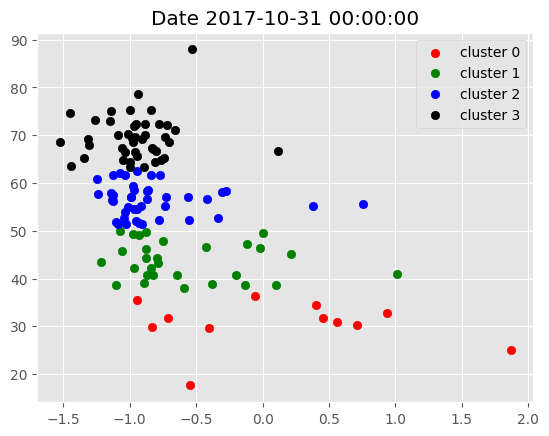

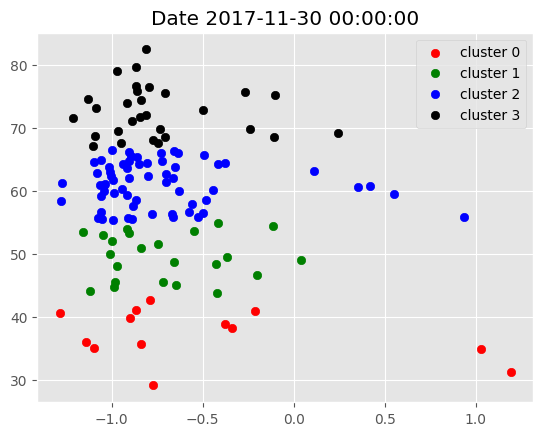

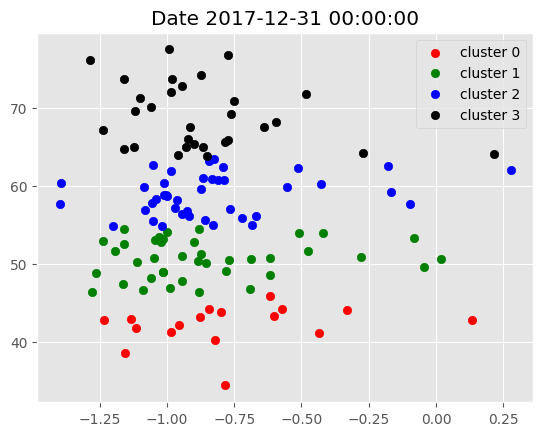

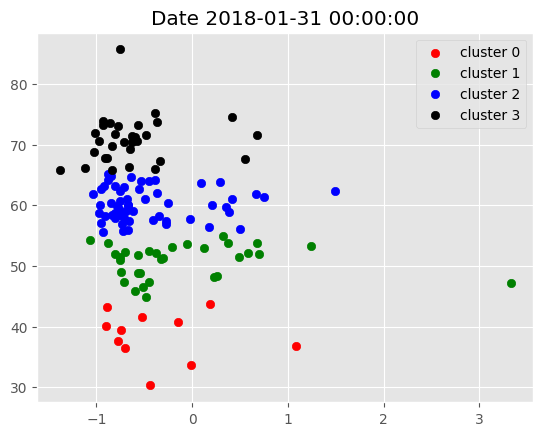

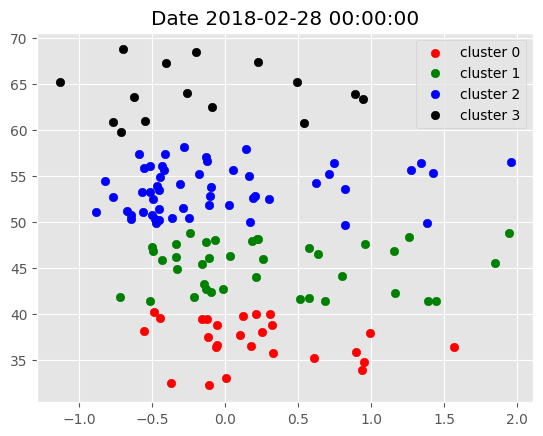

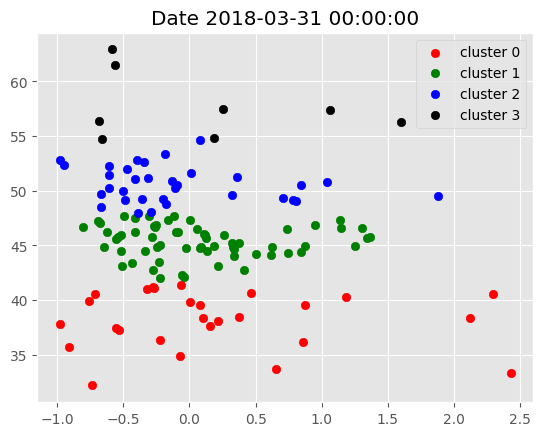

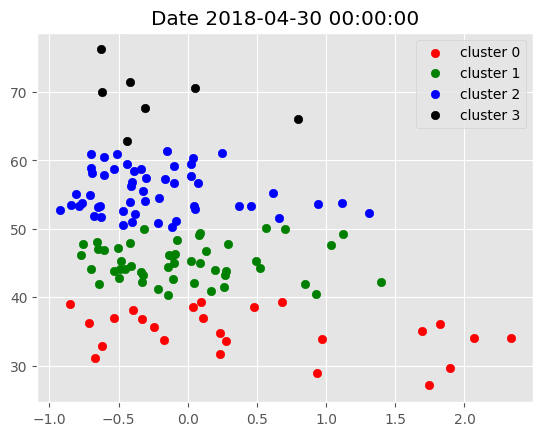

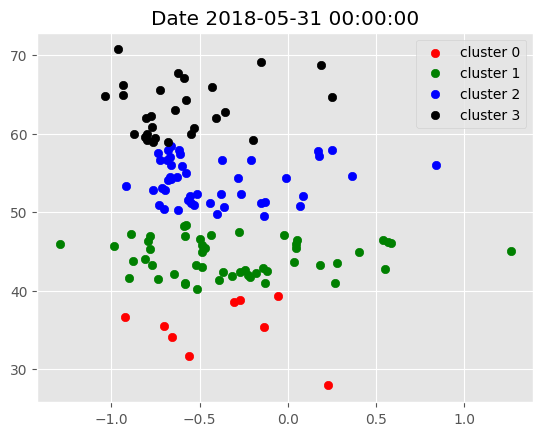

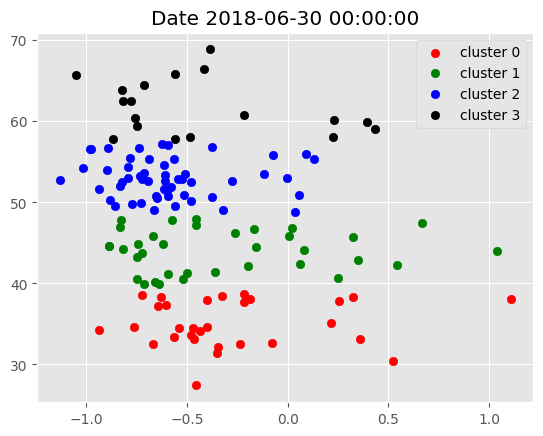

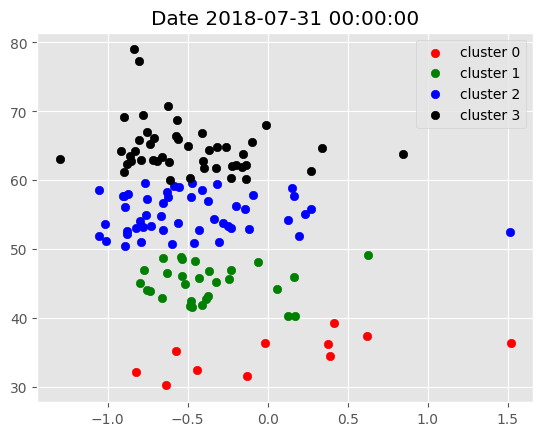

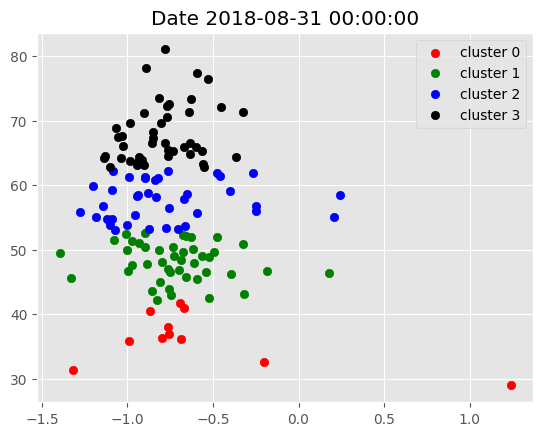

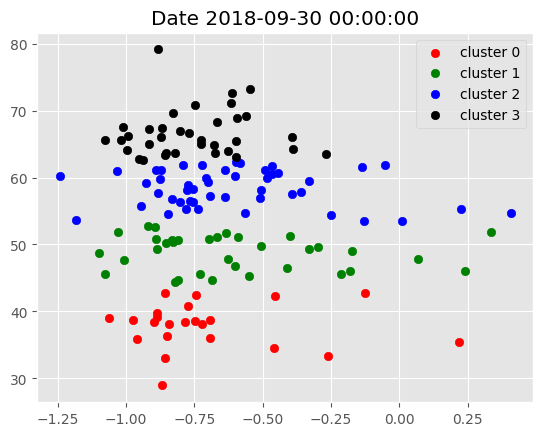

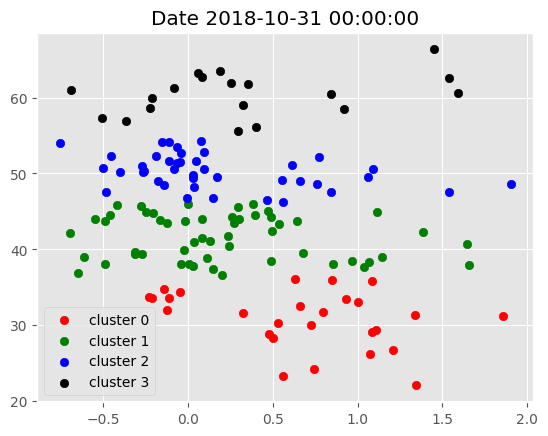

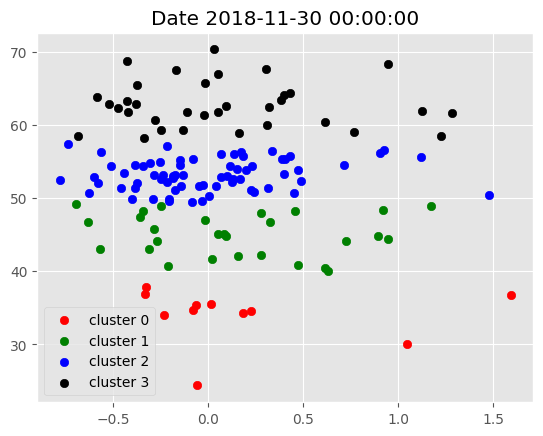

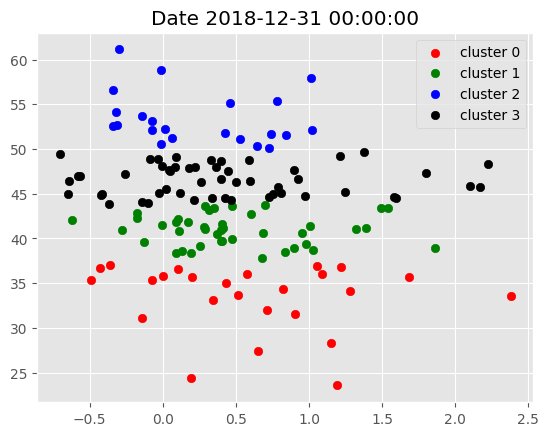

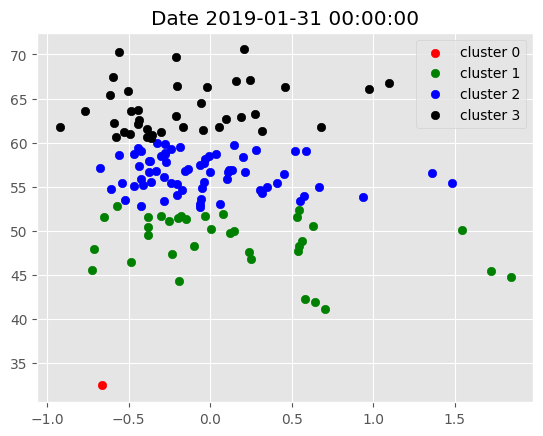

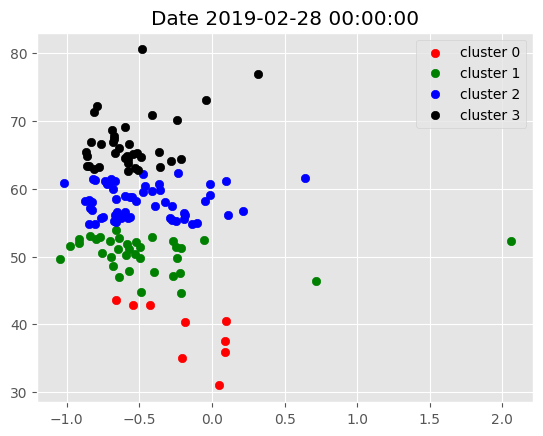

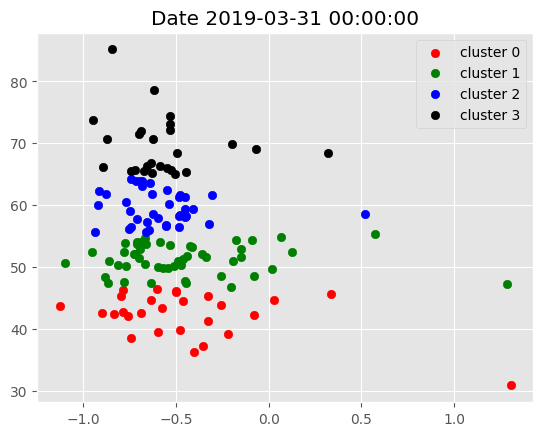

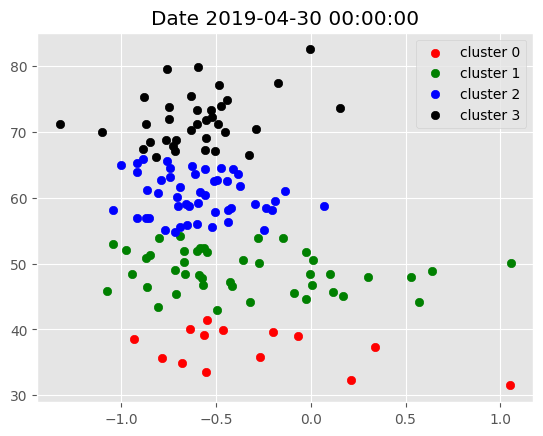

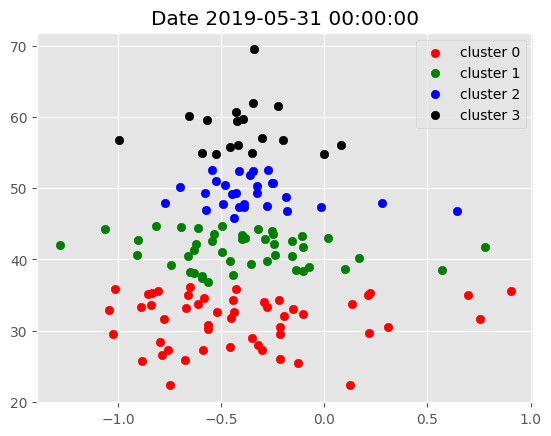

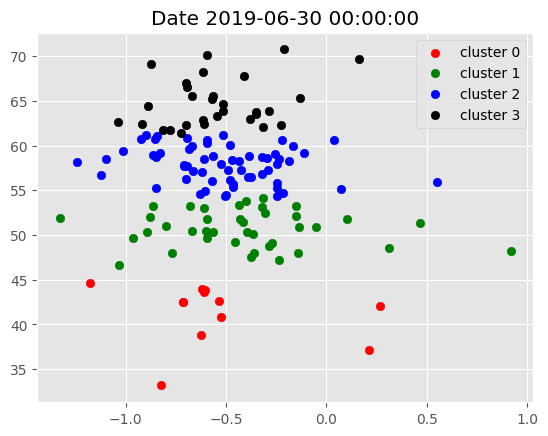

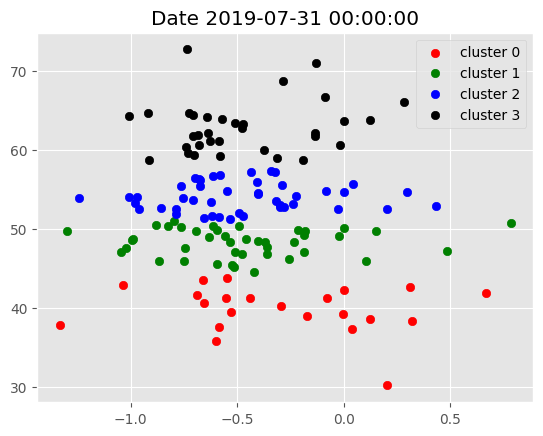

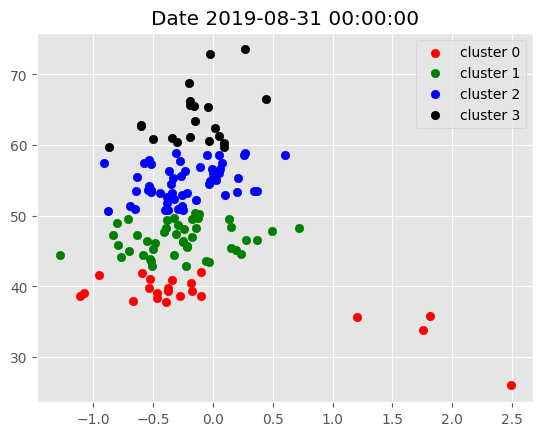

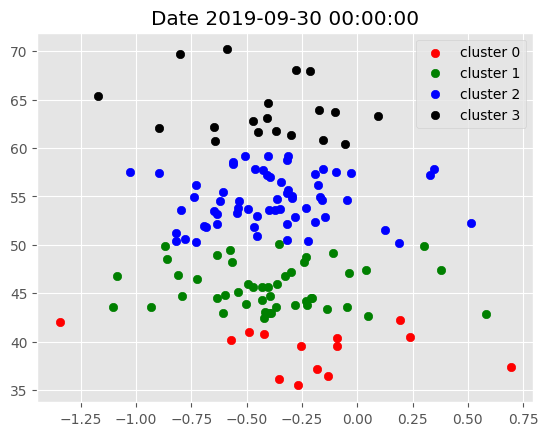

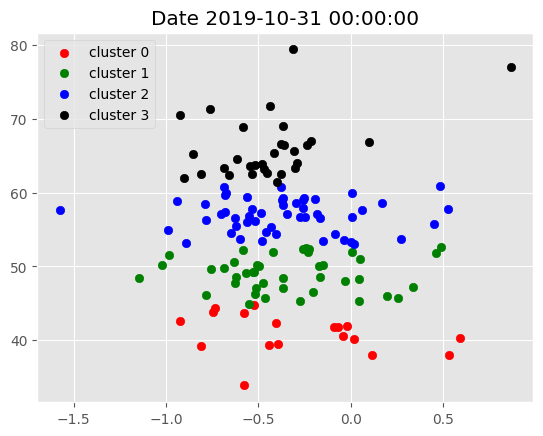

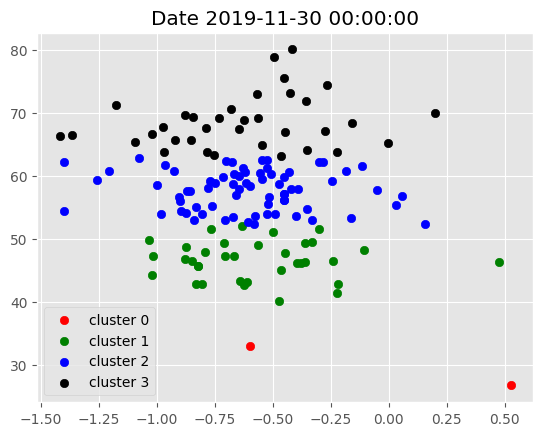

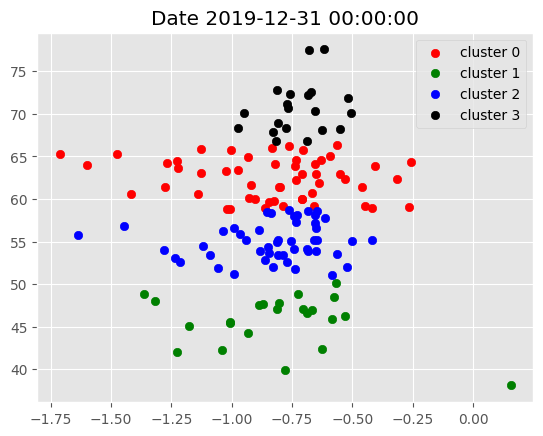

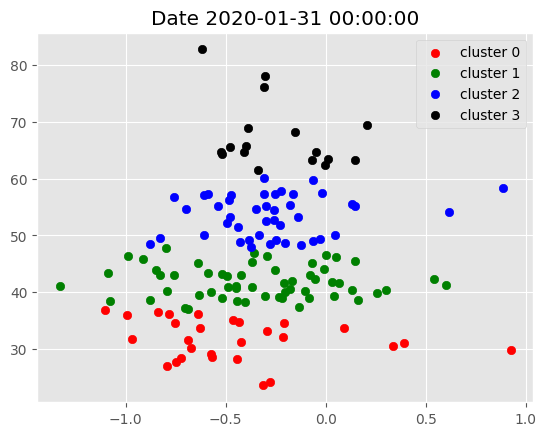

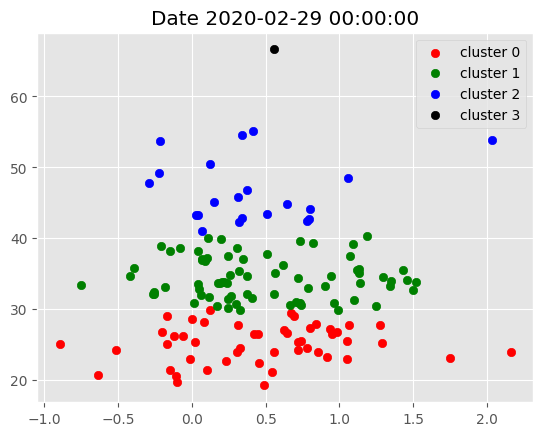

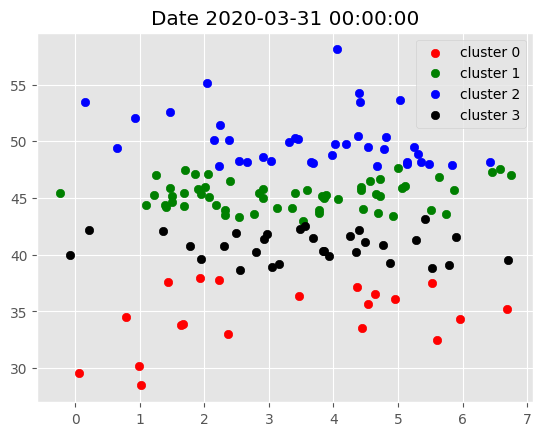

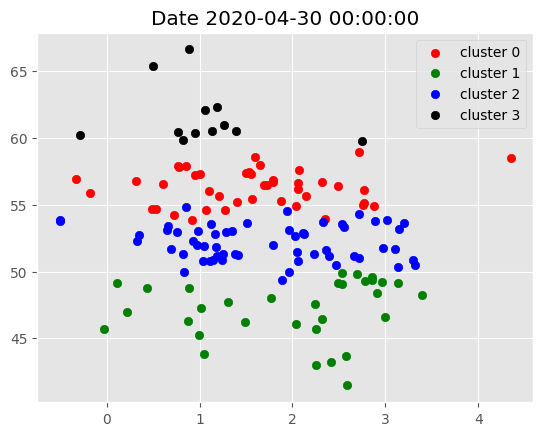

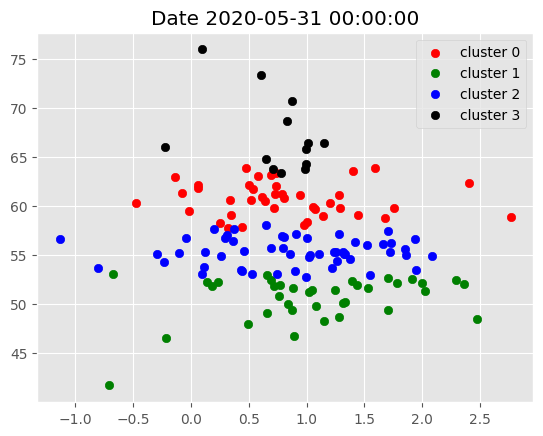

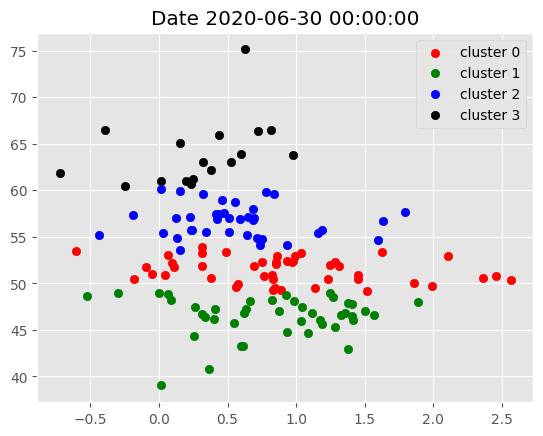

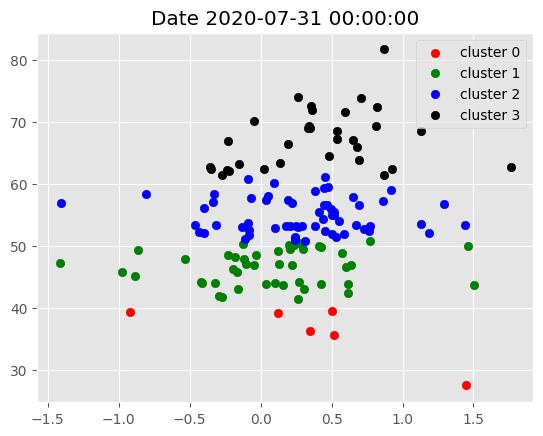

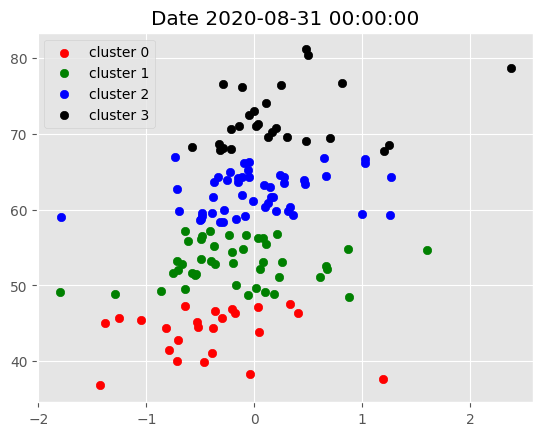

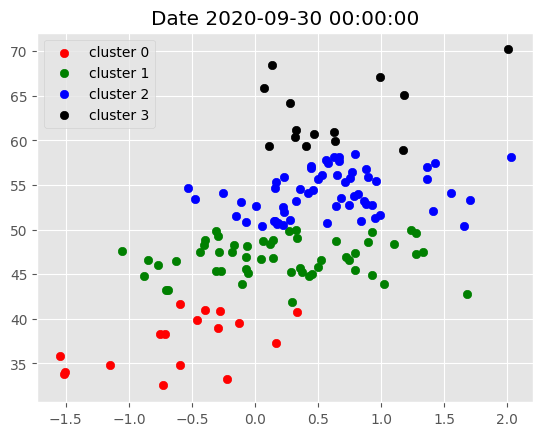

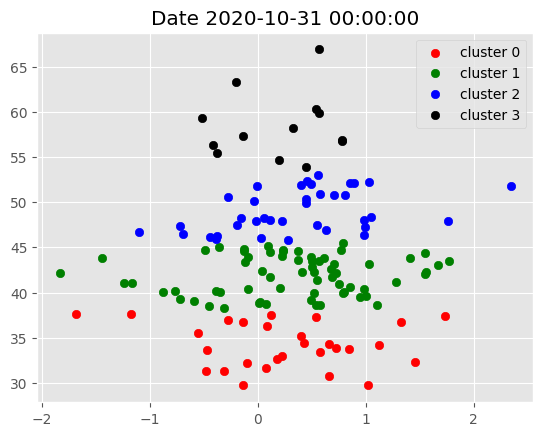

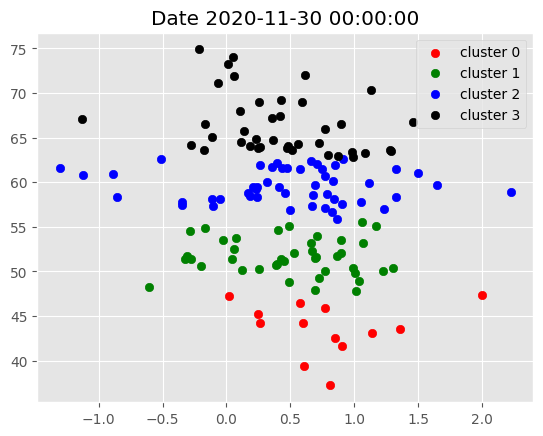

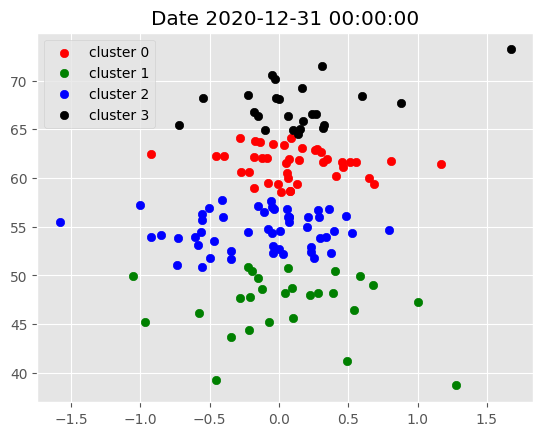

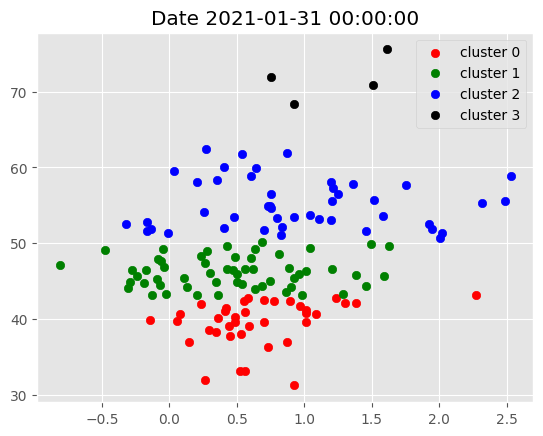

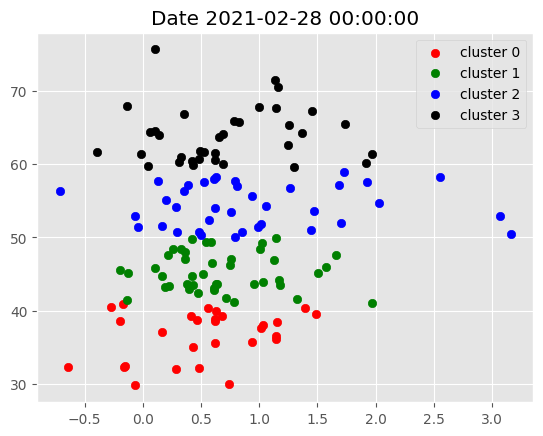

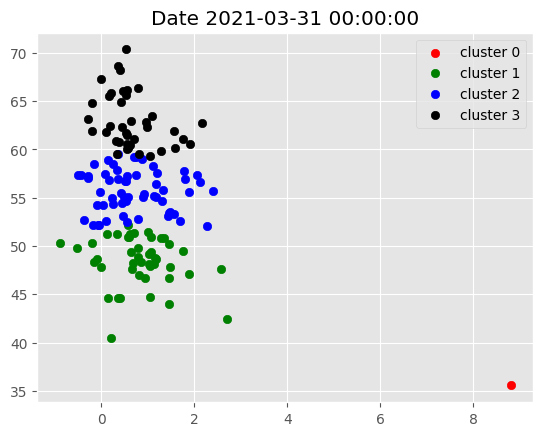

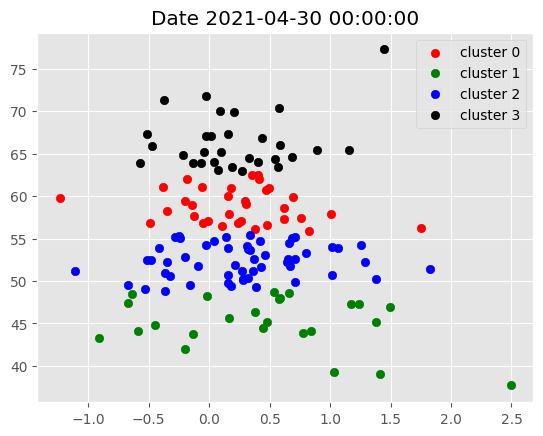

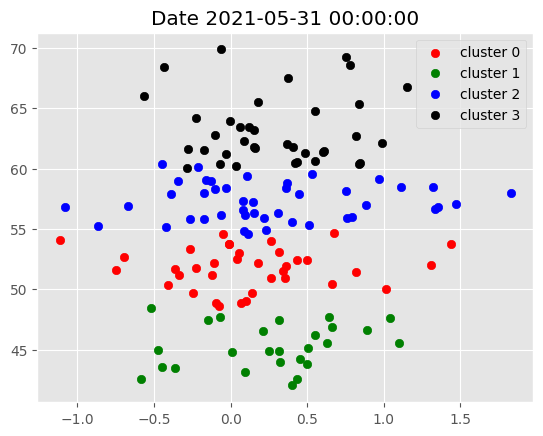

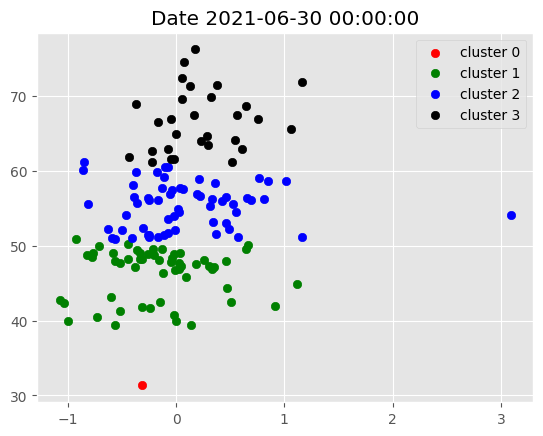

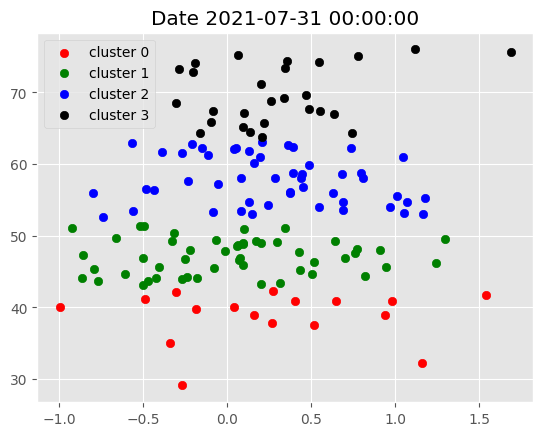

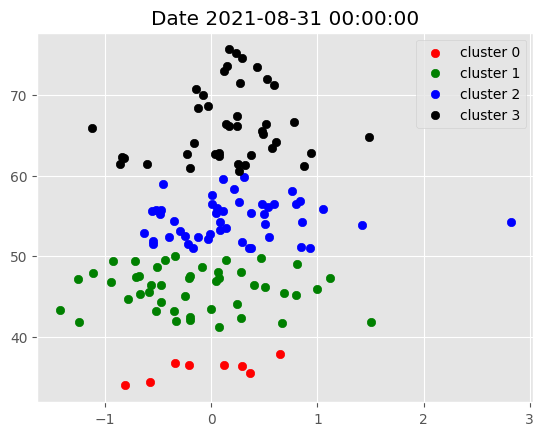

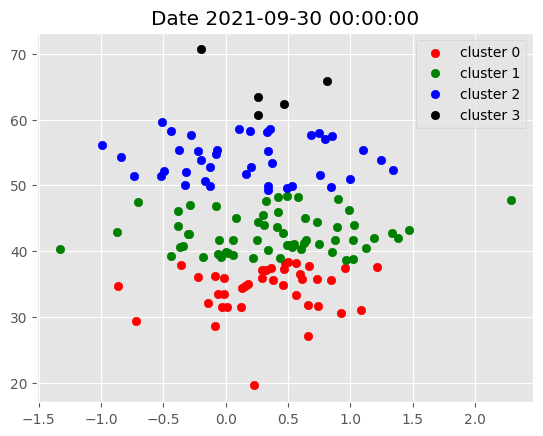

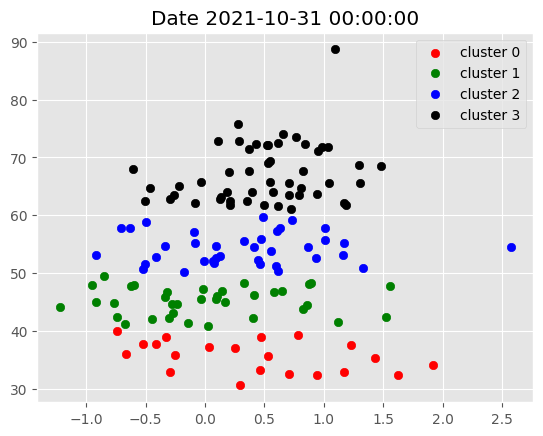

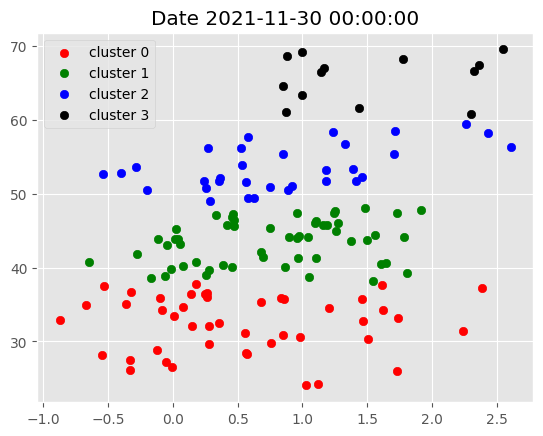

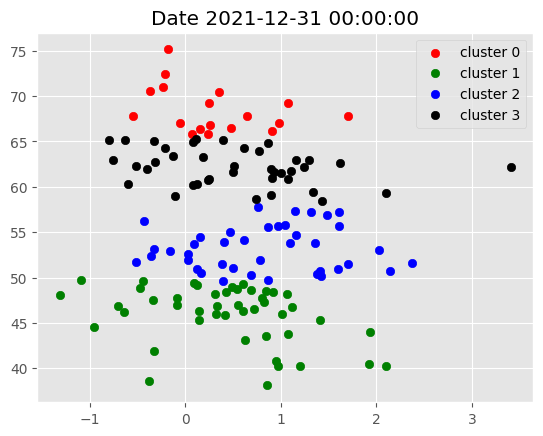

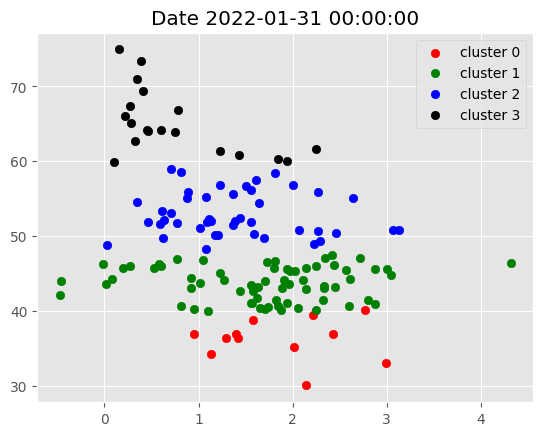

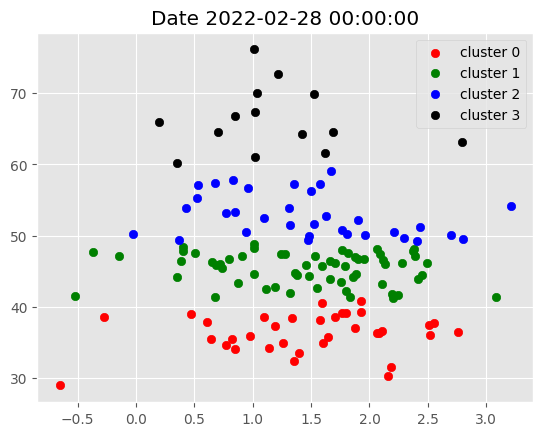

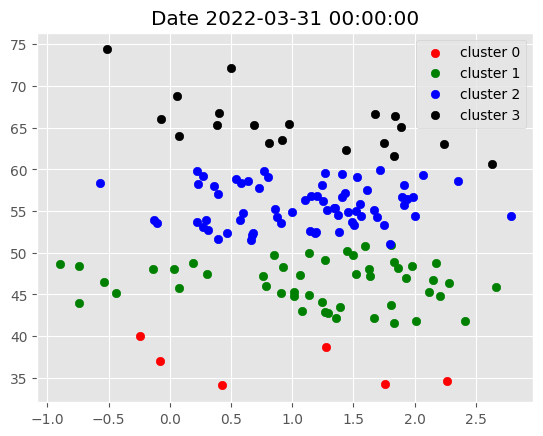

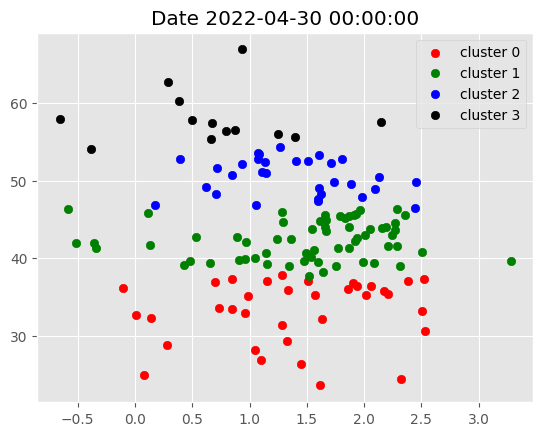

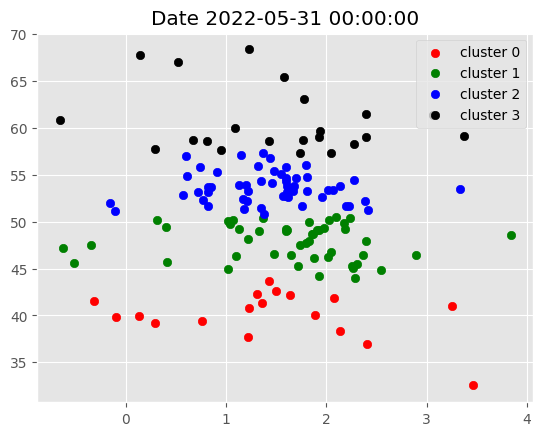

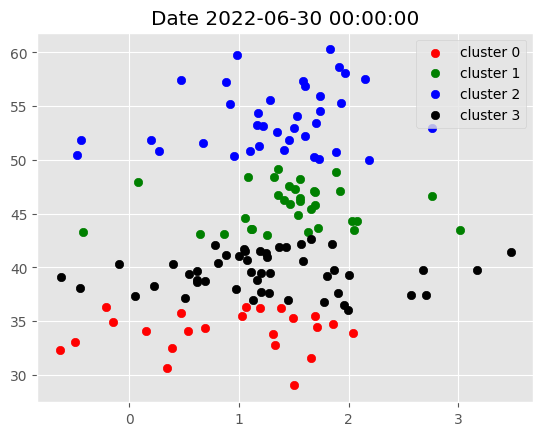

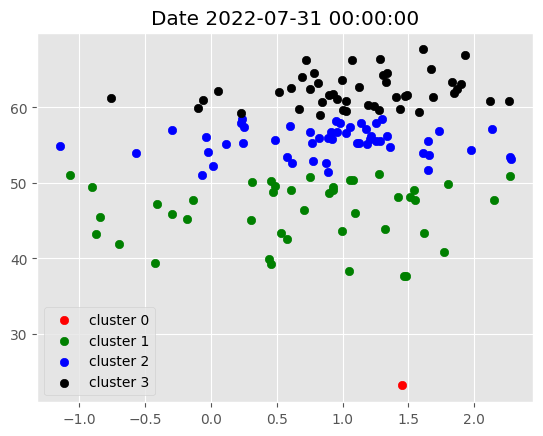

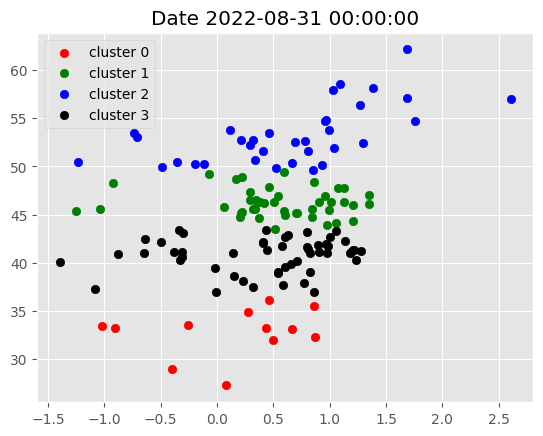

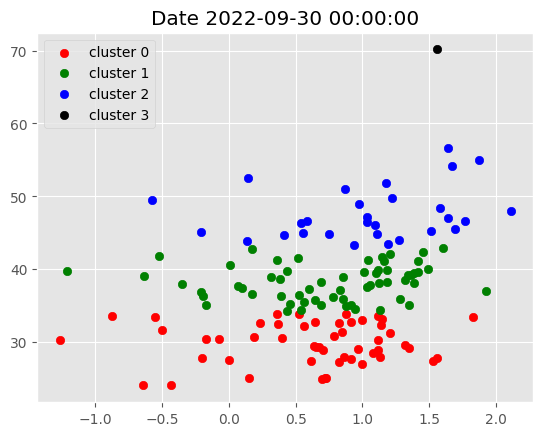

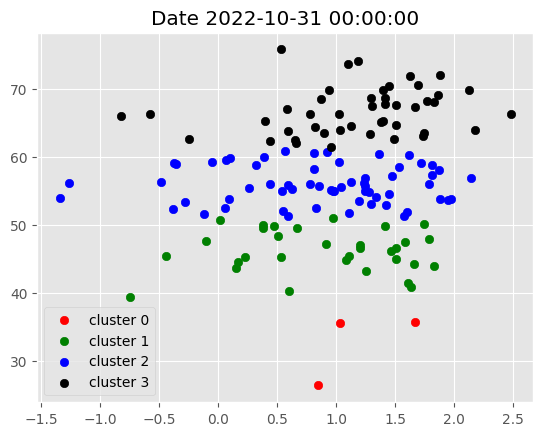

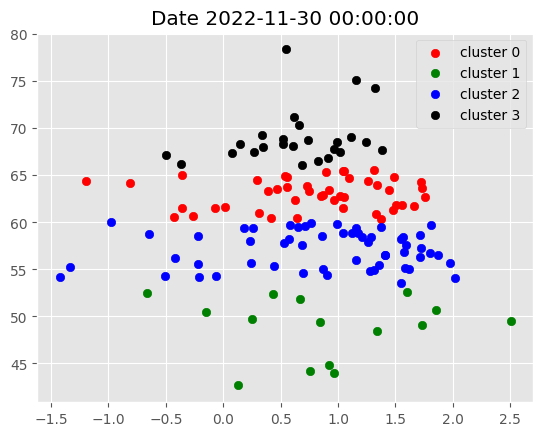

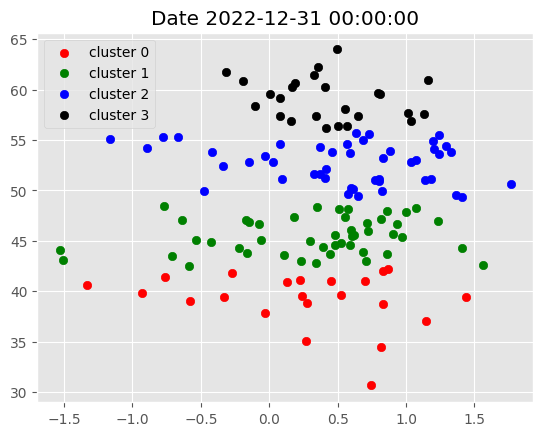

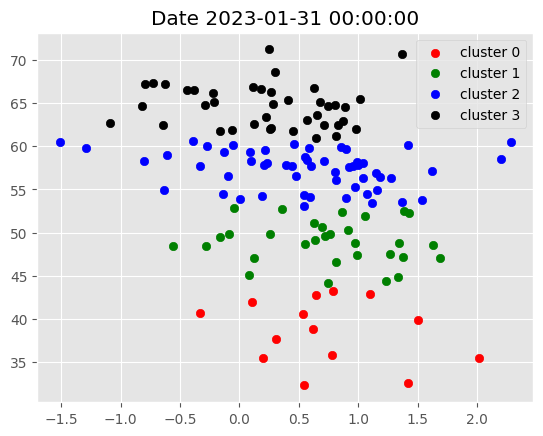

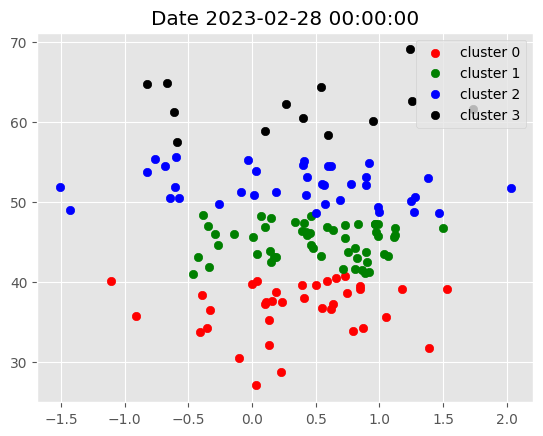

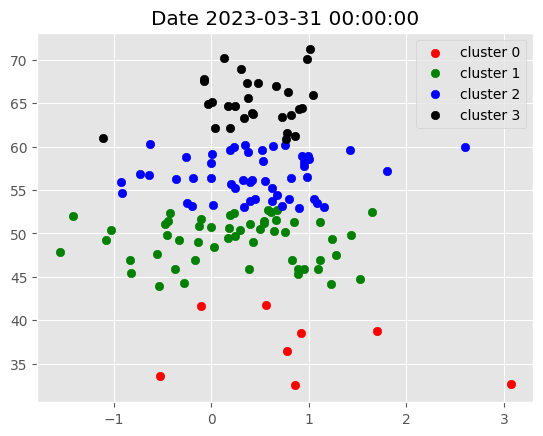

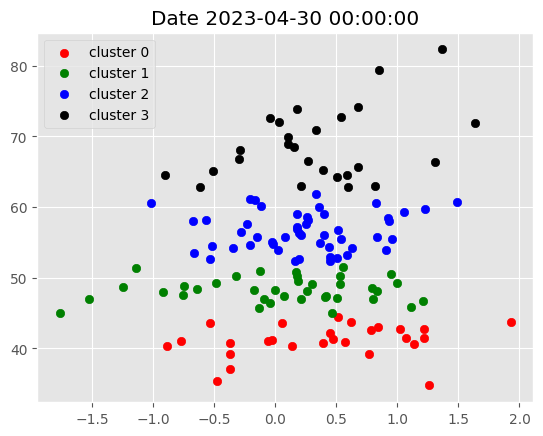

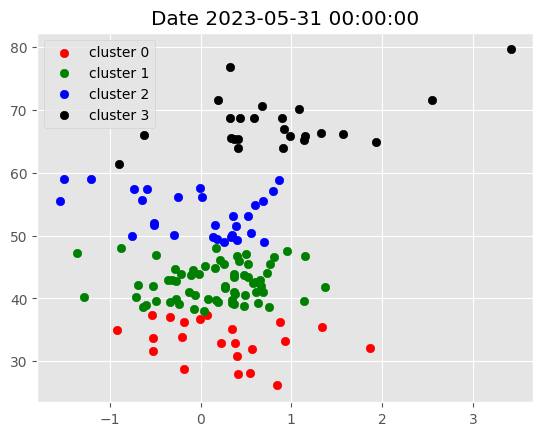

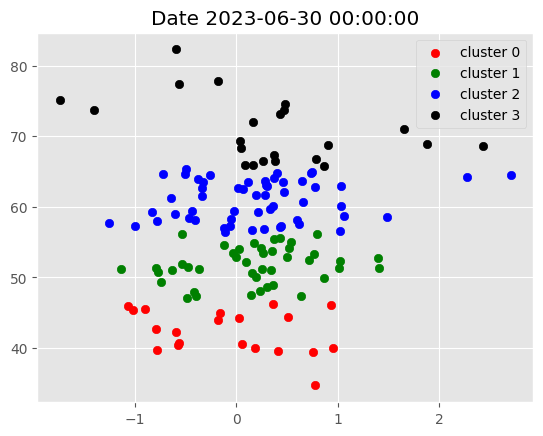

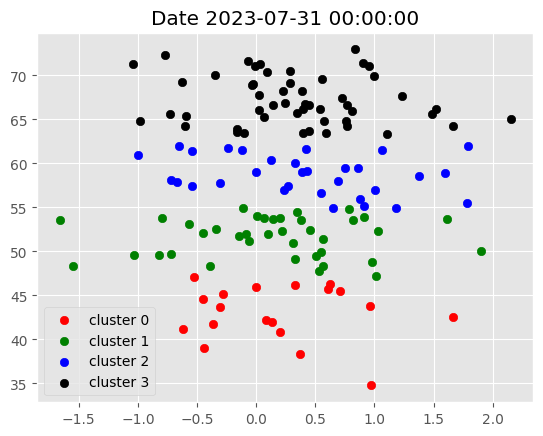

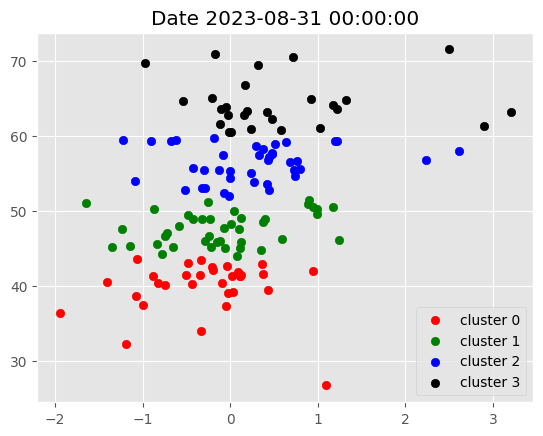

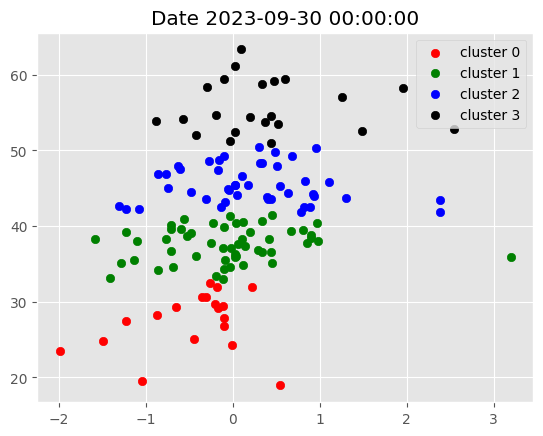

In [ ]:
plt.style.use('ggplot')
for i in data.index.get_level_values('Date').unique().tolist():
  g = data.xs(i,level=0)

  plt.title(f'Date {i}')
  plot_clusters(g)

# For each mont select assets based on the cluster

In [ ]:
## Create a dictorioni with the tickers of the stoks to invest the next montf
filtered_df=data[data['cluster']==3].copy()

# Create a list with tickers with indexes one month in the future
filtered_df = filtered_df.reset_index(level=1)
# Increase the date
filtered_df.index = filtered_df.index + pd.DateOffset(1)
# Reset the indexes
filtered_df=filtered_df.reset_index().set_index(['Date','Ticker'])

dates = filtered_df.index.get_level_values('Date').unique().tolist()

fixed_dates = {}

for d in dates:
  fixed_dates [d.strftime('%Y-%m-%d')] = filtered_df.xs(d,level=0).index.to_list()

fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  '

# Define Portfoli optimization funtion

In [ ]:
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 967.7 kB/s eta 0:00:00


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices,lower_bound=0):

  returns = expected_returns.mean_historical_return(prices=prices,
                                                    frequency=252)

  cov = risk_models.sample_cov(prices=prices,
                               frequency=252)

  ef = EfficientFrontier(expected_returns=returns,
                         cov_matrix=cov,
                         weight_bounds=(lower_bound,.1),
                          solver='SCS')
  weights = ef.max_sharpe()

  return ef.clean_weights()


In [ ]:
stocks = data.index.get_level_values(level=1).unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values(level=0).unique()[0] - pd.DateOffset(months=12),
                     end=data.index.get_level_values(level=0).unique()[-1])

[*********************100%%**********************]  156 of 156 completed


In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:
        ## For each start date take a end date a month later
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        ## Get the stoks have that month
        cols = fixed_dates[start_date]

        ##Compute one year ago date for optimization
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        ## Compeute yesterday date
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        #Create an optimization target dataset
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            # Get the optimal weights for each stok
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        # If error
        if success==False:
            # Set equal weights for all the stoks
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        # Create a temporal df to store the returns by the stoks in the period
        temp_df = returns_dataframe[start_date:end_date]
        # Merge with the weight df
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        # Create a column to store the ponderate return with the weight
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        ## Compute the sum of all the wegihted returns
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.001371
2017-11-02,0.003016
2017-11-03,0.006222
2017-11-06,0.002973
2017-11-07,0.002645
...,...
2023-09-25,0.003459
2023-09-26,-0.012075
2023-09-27,0.004926


# Visualize and compare to SP500

In [ ]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'},axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)
portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001371,0.001321
2017-11-02,0.003016,0.000388
2017-11-03,0.006222,0.003333
2017-11-06,0.002973,0.001547
2017-11-07,0.002645,-0.000696
...,...,...
2023-09-25,0.003459,0.004196
2023-09-26,-0.012075,-0.014800
2023-09-27,0.004926,0.000399
2023-09-28,0.008140,0.005781


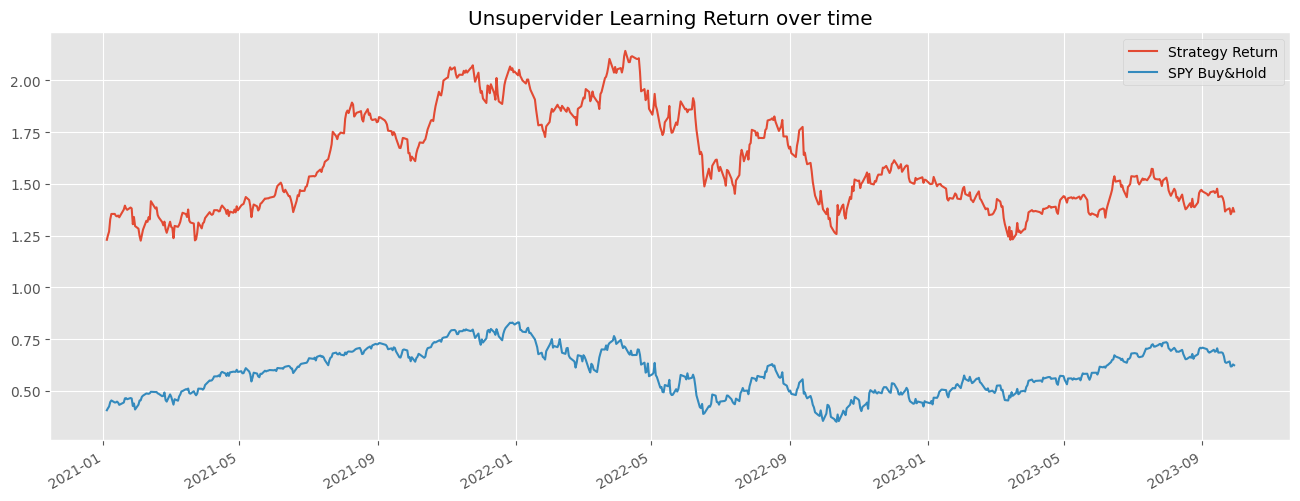

In [ ]:
plt.style.use('ggplot')

porfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

porfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervider Learning Return over time')
plt.show()



---

 # *Twiter sentiment analysis*

---



# Load the dataset


In [ ]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')



In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get the data

data_folder = '/content/drive/MyDrive/'
sentiment_df = pd.read_csv(os.path.join(data_folder,'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date','symbol'])

## Create a metric to compute the engagement
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

## Filter the relevant stocks per day
sentiment_df = sentiment_df[(sentiment_df['twitterLikes'] > 20) & (sentiment_df['twitterComments'] >10)]

sentiment_df


twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

# Calculate aggregate monthly and average sentiment

In [ ]:
## Rank the stocks using the engagement ratio
aggregate_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'),'symbol'])
[['engagement_ratio']].mean())

aggregate_df['rank'] = (aggregate_df.groupby(level=0)['engagement_ratio']
                        .transform(lambda x: x.rank(ascending=False)))

aggregate_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

#Select top 5 and fix the date for next month

In [ ]:
filtered_df = aggregate_df[aggregate_df['rank'] < 6].copy()

# Fix the months to have the bests stocks of the previus moth with the actual month
filtered_df=filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date','symbol'])
filtered_df

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
...                             ...   ...
2023-02-01 A               0.471572   5.0
           AES             0.533809   4.0
           BIIB            0.839303   1.0
           FCX             0.667387   3.0
           MDT             0.806841   2.0

[75 rows x 2 columns]

# Extract the stocks to form a monthly portfolio

In [ ]:
# Create a dictioanri with the dates and the stocks we want to monitorize the price
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates= {}

for d in dates:
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d,level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

# Download stock pirce for the selected stock/month

In [ ]:
# Create a list with the stocks to download the price
stock_list=sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stock_list,
                        start='2021-01-01',
                        end='2023-03-01')
prices_df

[*********************100%%**********************]  85 of 85 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Price        Adj Close                                                         \
Ticker               A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  116.195984  15.13  145.377365  126.830063   91.320778  102.596382   
2021-01-05  117.146004  15.43  145.220276  128.398178   92.265068  103.865761   
2021-01-06  120.358437  15.52  153.609940  124.076088   91.468033  103.649513   
2021-01-07  123.561081  15.38  154.921936  128.309967   92.447006  104.655640   
2021-01-08  124.442543  15.13  157.130234  129.417450   92.932137  104.947128   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  140.826324  15.56  139.628098  147.918762  143.472763  100.148918   
2023-02-23  141.936462  15.87  138.062881  148.405487  144.805893  100.012390   
2023-02-24  139.954102  15.56  134.990707  145.733398  145.415329   97.974098   
2023-02-27  140.925446  15.63  136.721222  146.935333  146.910324   97.301170   
2023-02-28  140.717300  15.98  140.930893  146.428741  146.548447   99.202919   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  71.591949  20.939247  148.645218  92.300003  ...  5732800   
2021-01-05  71.495361  21.642027  158.676254  92.769997  ...  4029500   
2021-01-06  72.066063  22.506990  170.528564  90.330002  ...  3612500   
2021-01-07  70.143257  22.281738  179.196198  95.160004  ...  3993700   
2021-01-08  69.519875  22.903425  179.293564  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  86.226349  24.251104  243.547516  76.610001  ...  2044600   
2023-02-23  86.121910  24.251104  250.860367  79.750000  ...  2066600   
2023-02-24  85.856079  24.184246  246.581360  78.089996  ...  2875100   
2023-02-27  85.514290  23.763981  253.993027  78.769997  ...  2459700   
2023-02-28  83.520515  23.572952  251.314941  78.580002  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 510 columns]

In [ ]:
prices_df.stack()

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2021-01-04 A       116.195984  118.639999  120.089996  117.110001  118.940002   
           AAL      15.130000   15.130000   15.880000   15.030000   15.850000   
           AAP     145.377365  157.339996  159.570007  155.960007  157.899994   
           AAPL    126.830063  129.410004  133.610001  126.760002  133.520004   
           ABBV     91.320778  105.410004  107.349998  103.860001  107.180000   
...                       ...         ...         ...         ...         ...   
2023-02-28 TMO     539.958923  541.760010  545.229980  538.890015  540.409973   
           TSLA    205.710007  205.710007  211.229996  203.750000  210.589996   
           TSN      57.050060   59.240002   60.259998   59.180000   60.049999   
           V       217.824509  219.940002  221.770004  219.500000  220.000000   
           XOM     105.258034  109.910004  111.360001  109.220001  111.239998   

Price                   Volume  
Date       Ticker               
2021-01-04 A         2030700.0  
           AAL      69732500.0  
           AAP        849100.0  
           AAPL    143301900.0  
           ABBV      9523400.0  
...                        ...  
2023-02-28 TMO       1188800.0  
           TSLA    153144900.0  
           TSN       3556300.0  
           V         5385400.0  
           XOM      18107000.0  

[45528 rows x 6 columns]

# Calculate returns with monthly rebalancing

In [ ]:
returns_df = np.log(prices_df['Adj Close']).diff().stack().dropna().unstack()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

    # Stocks to inves that month
    cols = fixed_dates[start_date]

    # Calculate the return of the equaly weighted portfolio
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    portfolio_df = pd.concat([portfolio_df,temp_df],axis=0)

portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


# Download NASDQ/QQQ prices and calculate retuns to compare

In [ ]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                      end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return').dropna()


portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)
portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017541
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


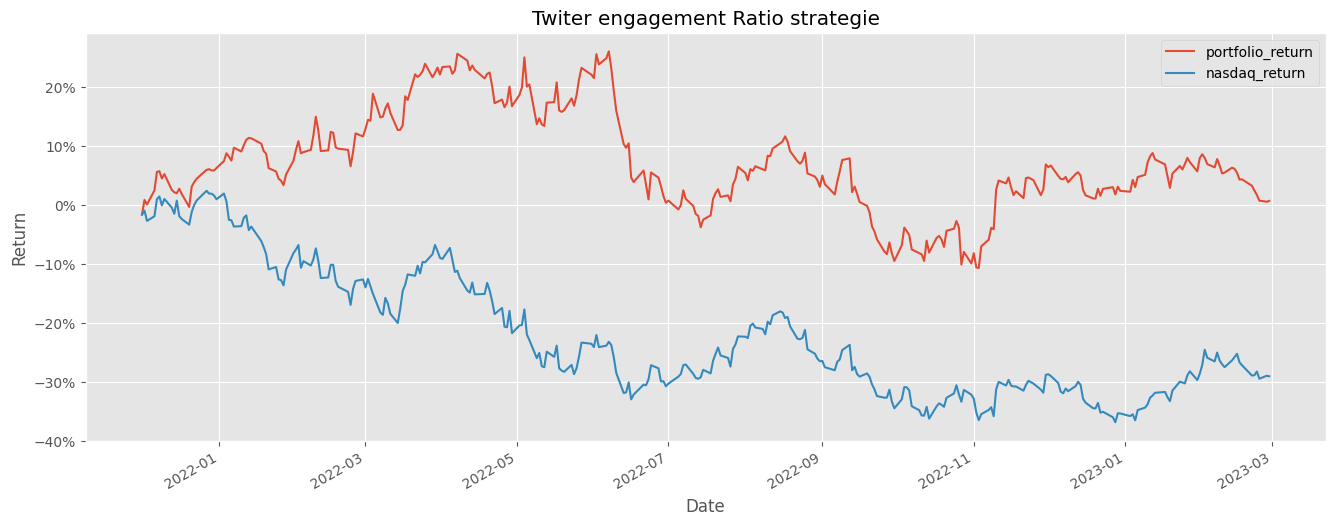

In [ ]:
import matplotlib.ticker as mtick
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title("Twiter engagement Ratio strategie")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')

plt.show()




---
# **Intraday strategie using GARCH Model**


---




# Load daily data and simutated 5-min data

In [4]:
!pip install arch
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=1dec8aa8e7a2f6ea72091506a70d5b63c3e62cb8982205819e034114ff31797c
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from tqdm import tqdm
import os
import warnings
import pandas_ta
warnings.filterwarnings('ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

data_folder = '/content/drive/MyDrive/'



Mounted at /content/drive


In [7]:
## Load and prepare daily data
daily_df = pd.read_csv(os.path.join(data_folder,'simulated_daily_data.csv'))
daily_df = daily_df.drop('Unnamed: 7',axis=1)
# # Fix the date

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')
daily_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07
...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09


In [8]:
## Load and prepare 5-min data

intraday_5min_df = pd.read_csv(os.path.join(data_folder,'simulated_5min_data.csv'))
intraday_5min_df = intraday_5min_df.drop('Unnamed: 6',axis=1)

# Fix the date
intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])
# Set the index
intraday_5min_df = intraday_5min_df.set_index('datetime')
intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)
intraday_5min_df

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


# Define function to fit GARCH model


In [10]:
# Calculate the variance
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()
daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020-01-01':]

def predict_volatility(x):

  best_model = arch_model(y=x,
                          p=1,
                          q=3).fit(update_freq=5,disp='off')

  variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

  return variance_forecast
daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()
daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions
Date,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286


# Create prediction premium and form daily signal

In [23]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()
daily_df


,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728,-0.705556,NaN,NaN
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651,-0.736678,NaN,NaN
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877,-0.644671,NaN,NaN
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618,-0.748362,NaN,NaN
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703,-0.713818,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.549073,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240810,0.546370,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.545350,NaN


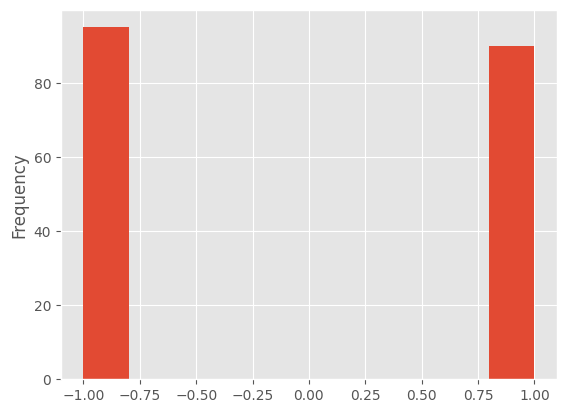

In [24]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

# Merge with intraday data nad calculate indicators

In [13]:
final_df = intraday_5min_df.reset_index().merge(daily_df[['signal_daily']].reset_index(),
                                     left_on='date',
                                     right_on='Date').set_index('datetime')

final_df = final_df.drop(['date','Date'],axis=1)
final_df

,open,low,high,close,volume,signal_daily
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN
...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN


In [14]:
# Calculate indicators
final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                legnth=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df


,open,low,high,close,volume,signal_daily,rsi,lband,uband
datetime,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,67.626988,6677.365065,6715.855435
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,68.036603,6679.544207,6716.559793
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,65.997545,6682.379916,6716.534084


<Axes: ylabel='Frequency'>

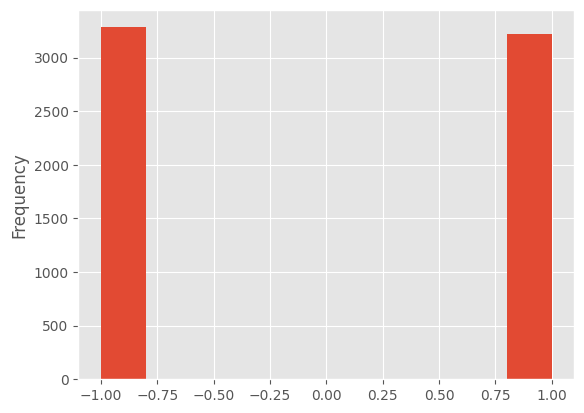

In [15]:
# Get intradat signals

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi'] > 70) &
                                                             (x['close'] > x['uband'])
                                            else ( -1 if (x['rsi'] < 30) &
                                                             (x['close'] < x['lband']) else np.nan),
                                             axis=1 )

final_df['signal_intraday'].plot(kind='hist')

# Generate entry points

In [16]:
final_df['return_signal'] = final_df.apply(lambda x : -1 if (x['signal_daily']==1) & (x['signal_intraday']==1)
                                            else( 1 if (x['signal_daily']==-1) & (x['signal_intraday']==-1)else np.nan)
                                           ,axis=1)
# Take the first signal as the daily signal and hold it until the day ends
final_df['return_signal']= final_df.groupby(pd.Grouper(freq='D'))['return_signal']\
                                    .transform(lambda x: x.ffill())

final_df[final_df['return_signal'] == 1]



,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return_signal
datetime,,,,,,,,,,,
2021-10-20 16:10:00,16554.2425,16493.0000,16560.790,16504.9500,211,-1.0,28.883905,16530.957410,16701.344590,-1.0,1.0
2021-10-20 16:15:00,16502.4250,16425.0000,16555.000,16477.5325,445,-1.0,25.866276,16505.363930,16708.287570,-1.0,1.0
2021-10-20 16:20:00,16477.4925,16402.1300,16500.250,16454.8375,220,-1.0,23.662546,16478.068048,16716.067202,-1.0,1.0
2021-10-20 16:25:00,16453.7750,16422.2775,16490.250,16422.2775,183,-1.0,20.910096,16446.656872,16726.321628,-1.0,1.0
2021-10-20 16:30:00,16422.4050,16400.0000,16451.255,16449.7500,213,-1.0,28.470447,16427.158587,16727.907663,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-08 23:35:00,5432.7325,5432.0675,5437.500,5433.7800,13,-1.0,44.539951,5430.867848,5447.187152,NaN,1.0
2023-03-08 23:40:00,5433.7800,5431.5500,5436.500,5432.5100,27,-1.0,42.968727,5430.045955,5447.315545,NaN,1.0
2023-03-08 23:45:00,5432.5100,5432.5100,5435.500,5433.8750,7,-1.0,45.206080,5429.588032,5446.858468,NaN,1.0


In [25]:
# Calculate the return
final_df['return'] = np.log(final_df['close']).diff()

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_signal']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()
daily_return_df

datetime
2021-09-29    0.000000
2021-09-30    0.000000
2021-10-01    0.000000
2021-10-02   -0.001728
2021-10-03    0.000000
                ...   
2023-09-14    0.000000
2023-09-15    0.000000
2023-09-16    0.000000
2023-09-17    0.000000
2023-09-18    0.000000
Freq: D, Name: strategy_return, Length: 720, dtype: float64

# Calculate dinal return

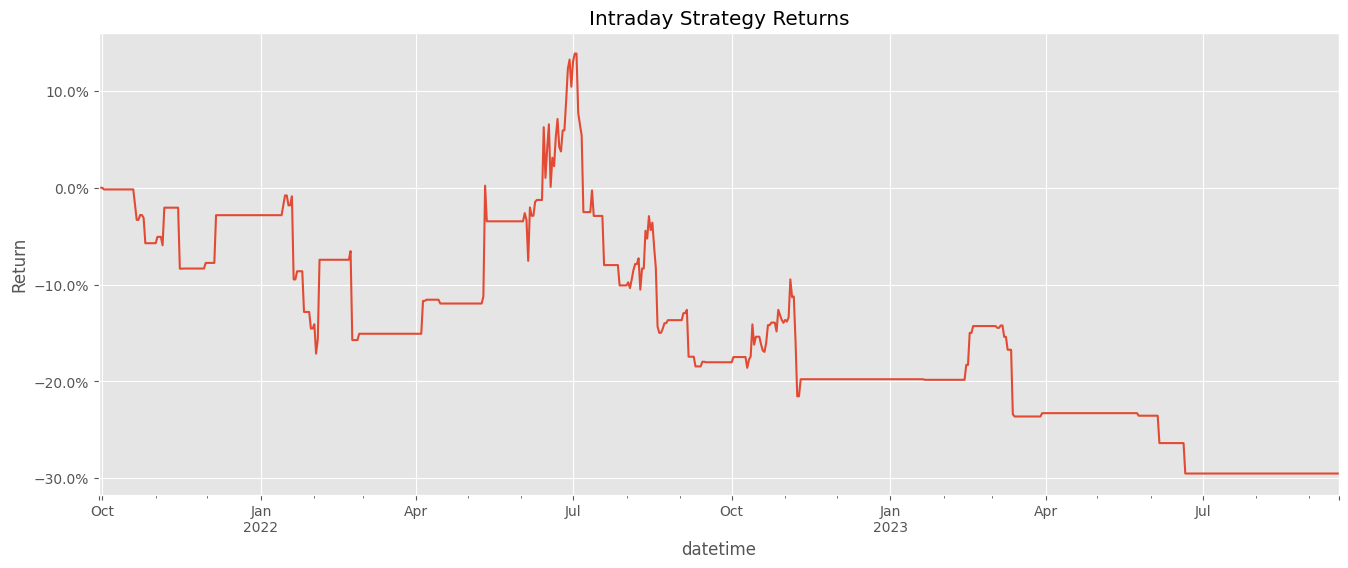

In [26]:
import matplotlib.ticker as mtick
stategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

stategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()